# **Assignment 2**, **dataset 3**


# Problem statement



### Loading the dataset

The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

https://arxiv.org/pdf/1511.08060

https://github.com/gabrieldgf4/PlantVillage-Dataset

For this assignment, you will make a model that predicts whether a bell pepper leaf comes from a healthy or unhealthy plant (binary classification). The healthy bell pepper leaf images are in the `Pepper,_bell___healthy` folder, while unhealthy cherry leaf images are in `Pepper,_bell___Bacterial_spot`. You are allowed to use a pretrained model that you transfer to this problem, if you whish so. Keep in mind that the dataset is somewhat uneven between the classes. Make sure to apply a technique to mitigate for that.

In [1]:
# Download the dataset
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 54511, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 54511 (delta 36), reused 0 (delta 0), pack-reused 54403 (from 1)
Receiving objects: 100% (54511/54511), 806.27 MiB | 26.46 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Updating files: 100% (54306/54306), done.


## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [2]:
import os
DIR = "PlantVillage-Dataset"
#os.listdir('PlantVillage-Dataset') # We are only interested in the healthy and unhealthy bell pepper images
healthy_path = os.path.join(DIR, "Pepper,_bell___healthy")
unhealthy_path = os.path.join(DIR, "Pepper,_bell___Bacterial_spot")

First of all, we check our data distribution. We can see that we have more positive (healthy) than negative (unhealthy) examples; our dataset is thus imbalanced.

In [3]:
healthy_images = os.listdir(healthy_path)
unhealthy_images = os.listdir(unhealthy_path)
print("Healthy bell pepper images:", len(healthy_images))
print("Unhealthy bell pepper images:", len(unhealthy_images))
print("Total data set size:", len(healthy_images)+len(unhealthy_images))

Healthy bell pepper images: 1476
Unhealthy bell pepper images: 997
Total data set size: 2473


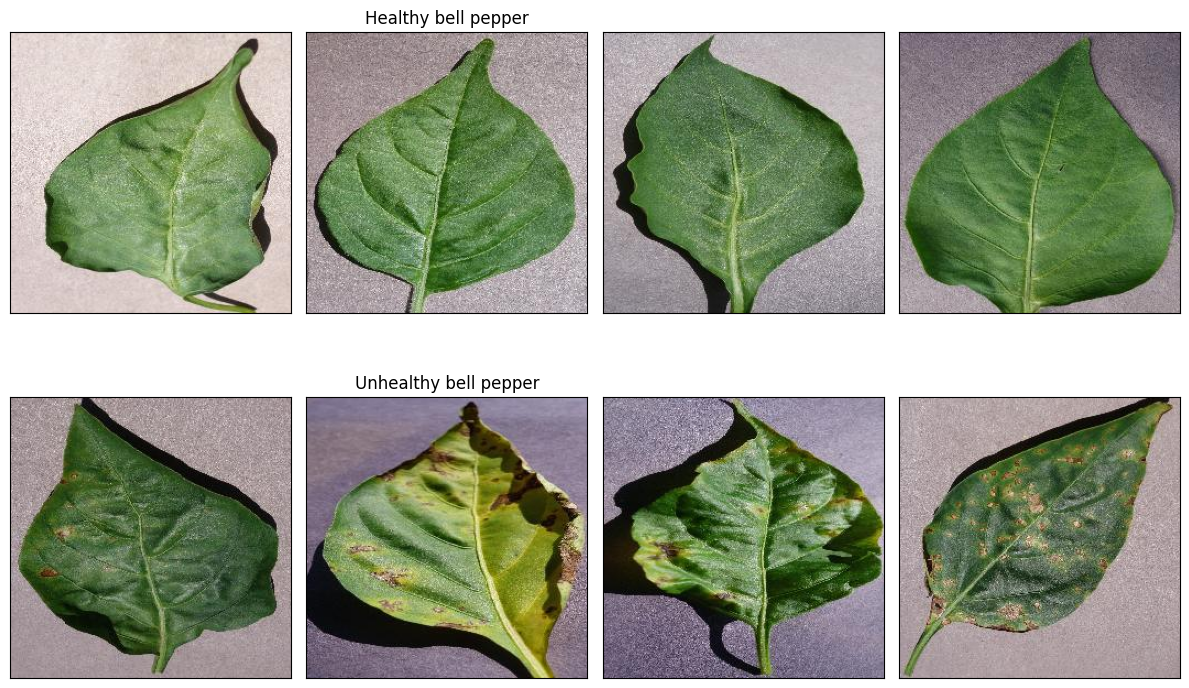

In [4]:
# inspect some examples for healthy and unhealthy bell peppers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

healthy_images_sample = random.sample(healthy_images, 4)
unhealthy_images_sample = random.sample(unhealthy_images, 4)

plt.figure(figsize=(12, 8)) # code modified after Computer_vision_exercise_solutions.ipynb

for i, file_name in enumerate(healthy_images_sample):
  #print(file_name) # we have JPG images
  image = mpimg.imread(os.path.join(healthy_path,file_name))
  #print(image.shape) # (256, 256, 3) --> 256*256 pixels, colour images
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Healthy bell pepper")


for i, file_name in enumerate(unhealthy_images_sample):
  image = mpimg.imread(os.path.join(unhealthy_path,file_name))
  ax = plt.subplot(2, 4, i+5)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Unhealthy bell pepper")

plt.tight_layout()
plt.show()

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

First, we have to create a Dataset from the images including their label (0 or 1 since we are dealing with a binary classification task here). In the getitem()method we then apply the transformations (here resizing to a size our resnet model can work with and a conversion to a tensor).

In [16]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# code modified from: https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html, assessed Aug 2, 2025 and https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660.

# define a transform

transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # data preprocessing for ResNet18 after https://pytorch.org/hub/pytorch_vision_resnet/
])

# create labels and merge images together
image_paths = []
labels = []
unhealthy_image_paths = [] # use this for the augmented dataset

for fname in os.listdir(healthy_path):
    image_paths.append(os.path.join(healthy_path, fname))
    labels.append(1) # label 1 for healthy bell pepper

for fname in os.listdir(unhealthy_path):
    image_paths.append(os.path.join(unhealthy_path, fname))
    unhealthy_image_paths.append(os.path.join(unhealthy_path, fname))
    labels.append(0) # label 0 for unhealthy bell pepper


class BellPepperDataset(Dataset):
    """BellPepper Dataset."""

    def __init__(self, image_paths, labels, transform=None):
        """
        Arguments:
            image_paths (list): List of image paths.
            labels (list): List of labels.
            transform (callable, optional): Optional transform to be applied on a sample. For the normal data set, we just resize and convert image to Tensor.
        """
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

(tensor([[[0.6353, 0.7020, 0.6510,  ..., 0.6863, 0.8941, 0.6745],
         [0.6196, 0.6863, 0.6588,  ..., 0.7647, 0.7294, 0.7333],
         [0.6118, 0.6588, 0.6549,  ..., 0.6431, 0.7059, 0.8000],
         ...,
         [0.6588, 0.5804, 0.6549,  ..., 0.7569, 0.7569, 0.7529],
         [0.5922, 0.5961, 0.7373,  ..., 0.7686, 0.7647, 0.7569],
         [0.5569, 0.6784, 0.6549,  ..., 0.7686, 0.7569, 0.7451]],

        [[0.5804, 0.6471, 0.5961,  ..., 0.6471, 0.8549, 0.6353],
         [0.5647, 0.6314, 0.6039,  ..., 0.7255, 0.6902, 0.6941],
         [0.5569, 0.6039, 0.6000,  ..., 0.6039, 0.6667, 0.7608],
         ...,
         [0.5961, 0.5176, 0.5922,  ..., 0.7137, 0.7137, 0.7176],
         [0.5412, 0.5451, 0.6863,  ..., 0.7255, 0.7216, 0.7216],
         [0.5059, 0.6275, 0.6039,  ..., 0.7255, 0.7137, 0.7098]],

        [[0.5804, 0.6471, 0.5961,  ..., 0.6510, 0.8588, 0.6392],
         [0.5647, 0.6314, 0.6039,  ..., 0.7294, 0.6941, 0.6980],
         [0.5569, 0.6039, 0.6000,  ..., 0.6078, 0.6706, 0

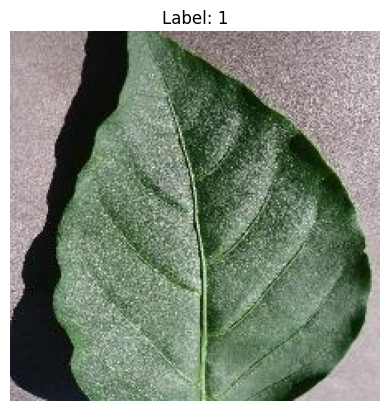

In [17]:
dataset = BellPepperDataset(image_paths, labels, transform)
print(dataset[0])
import torchvision.transforms.functional as TF

image, label = dataset[0]
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

In [ ]:
# Oversampling towards minority class (unhealthy bell pepper) with augmentation of negative examples
from torch.utils.data import ConcatDataset

transform_augmented = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15), # rotate by 15 degrees
    transforms.RandomHorizontalFlip(), # random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

size_augmented_negative_data = len(healthy_images)-len(unhealthy_images)
print(size_augmented_negative_data)
images_to_augment = random.sample(unhealthy_image_paths,size_augmented_negative_data)


class BellPepperDataset_augmented(Dataset):
    """BellPepper Dataset of unhealthy plants, used to balance classes via data augmentation/oversampling of minority class."""

    def __init__(self, image_paths, transform=None):
        """
        Arguments:
            image_paths (list): List of image paths.
            labels (list): List of labels.
            transform (callable, optional): Optional transform to be applied on a sample. For the normal data set, we just resize and convert image to Tensor.
        """
        self.transform = transform
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = 0 # we just augment the negative examples since its the minority class

        if self.transform:
            image = self.transform(image)

        return image, label


augmented_dataset = BellPepperDataset_augmented(
    image_paths=images_to_augment,
    transform=transform_augmented
)

# concatenate data sets

combined_dataset = ConcatDataset([dataset, augmented_dataset])
print(len(combined_dataset))

479
2952


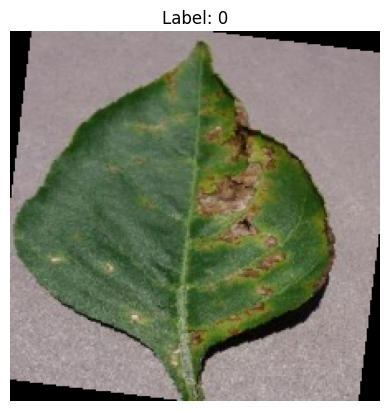

In [ ]:
import torchvision.transforms.functional as TF

image, label = augmented_dataset[10]
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [11]:
from torch.utils.data import random_split
import torch

dataset_len = len(dataset)
print(dataset_len)

# code modified from Computer_vision_exercise_solutions (Applied AI)

data_test_len  = int(dataset_len * 0.1)  # 10% test set
data_valid_len = int(dataset_len * 0.1)  # 10% valid set
data_train_len = dataset_len - data_test_len - data_valid_len

data_train, data_eval, data_test = torch.utils.data.random_split(dataset, [data_train_len, data_valid_len, data_test_len])

loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

2473


In [ ]:
dataset_len = len(combined_dataset)
print(dataset_len)

# code modified from Computer_vision_exercise_solutions (Applied AI)

data_test_len  = int(dataset_len * 0.1)  # 10% test set
data_valid_len = int(dataset_len * 0.1)  # 10% valid set
data_train_len = dataset_len - data_test_len - data_valid_len

data_train, data_eval, data_test = torch.utils.data.random_split(combined_dataset, [data_train_len, data_valid_len, data_test_len]) # TEST SHOULD NOT HAVE AUGMENTED???

# here combine training data + augmented data set 2**(len(data_train) from data_augmented) TO DOOOOO
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0,),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

### Baseline

As a baseline, I choose a simple CNN: LeNet.

In [21]:
# baseline: LeNet, code modified after Computer_vision_exercise_solutions.ipynb and
import torch.nn as nn

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 54 * 54, 120), nn.ReLU(), # CHECK HOW TO CALCULATE THAT HERE
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 1) # binary classification
)

print(baseline_model)
# input (batch_size, 3, 224, 224)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=46656, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)


### Transfer Learning with a pre-trained model

As a more complex model, I finetuned the classification head of a pre-trained ResNet18 from torch vision models.

In [22]:
from torchvision import models

# build own classifier with ResNet backbone/feature extractor
class CustomResNetModel(nn.Module):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True) # ResNet18 backbone (pre-trained)

        for param in self.base_model.parameters(): # freeze all parameters, we only want to finetune the classification head
            param.requires_grad = False

        num_features = self.base_model.fc.in_features # modified after https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e
        self.base_model.fc = nn.Linear(num_features, 1)  # binary classification

    def forward(self, x):
        return self.base_model(x)

resnet_model = CustomResNetModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)
print(resnet_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### Training function

In [23]:
import numpy as np
import time
from tqdm import tqdm


def training_loop_simple(num_epochs, model, loaders, loss_f, optimizer):
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_val = []
    training_time = []
    min_valid_loss = np.inf

    model.to(device)

    for epoch in range(num_epochs):
        time_epoch_start = time.time()

        # Train the model
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device) # BCEWithLogitLoss() needs floating point labels, unsqueeze(1) adds a dimension so there is not a mismatch between output and labels
            # print(images.shape)
            # print(labels.shape)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_f(output, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct = (preds == labels).float().sum()
            # print(correct)
            epoch_train_acc += (correct / labels.size(0)).item()

        avg_train_loss = epoch_train_loss / len(loaders['train'])
        avg_train_acc = epoch_train_acc / len(loaders['train'])

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        with torch.no_grad():
            for i, (images_v, labels_v) in tqdm(enumerate(loaders['validation']), total=len(loaders['validation'])):
                images_v, labels_v = images_v.to(device), labels_v.float().unsqueeze(1).to(device)
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                correct = (preds == labels_v).float().sum()
                epoch_val_acc += (correct / labels_v.size(0)).item() # CHECK SOURCE

        avg_val_loss = epoch_val_loss / len(loaders['validation'])
        avg_val_acc = epoch_val_acc / len(loaders['validation'])

        time_epoch_end = time.time()
        epoch_time = time_epoch_end - time_epoch_start

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Acc: {avg_train_acc:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {avg_val_acc:.4f}')
        print('-------------------')

        loss_train.append(avg_train_loss)
        loss_valid.append(avg_val_loss)
        acc_train.append(avg_train_acc)
        acc_val.append(avg_val_acc)
        training_time.append(epoch_time)

        if min_valid_loss > avg_val_loss:
            print(f'Validation Loss Decreased ({min_valid_loss:.4f} --> {avg_val_loss:.4f}) \t Saving The Model')
            min_valid_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(folder, 'saved_model.pth'))

    print(f"Average training time per epoch on {device}:", (sum(training_time) / len(training_time)/60), "minutes")
    print("Total training time:", sum(training_time)/60, "minutes")

    return loss_train, loss_valid, acc_train, acc_val


  def plot_training_curves(loss_train, loss_valid, acc_train, acc_val):
    """
    Plots training and validation loss and accuracy over epochs.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # loss
    axs[0].plot(range(len(loss_train)), loss_train, label='train')
    axs[0].plot(range(len(loss_valid)), loss_valid, label='valid', color='magenta')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # accuracy
    axs[1].plot(range(len(acc_train)), acc_train, label='train')
    axs[1].plot(range(len(acc_val)), acc_val, label='valid', color='magenta')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Train the baseline model

cuda


100%|██████████| 25/25 [00:00<00:00, 50.53it/s]


Epoch 1
Training Loss: 0.4810, Training Acc: 0.7762
Validation Loss: 0.2716, Validation Acc: 0.9143
-------------------
Validation Loss Decreased (inf --> 0.2716) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 51.87it/s]


Epoch 2
Training Loss: 0.1967, Training Acc: 0.9384
Validation Loss: 0.0904, Validation Acc: 0.9720
-------------------
Validation Loss Decreased (0.2716 --> 0.0904) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 51.35it/s]


Epoch 3
Training Loss: 0.1309, Training Acc: 0.9596
Validation Loss: 0.1102, Validation Acc: 0.9600
-------------------


100%|██████████| 25/25 [00:00<00:00, 51.82it/s]


Epoch 4
Training Loss: 0.0703, Training Acc: 0.9788
Validation Loss: 0.0905, Validation Acc: 0.9680
-------------------


100%|██████████| 25/25 [00:00<00:00, 52.90it/s]


Epoch 5
Training Loss: 0.0306, Training Acc: 0.9934
Validation Loss: 0.0479, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.0904 --> 0.0479) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 52.47it/s]


Epoch 6
Training Loss: 0.0101, Training Acc: 0.9995
Validation Loss: 0.0630, Validation Acc: 0.9840
-------------------


100%|██████████| 25/25 [00:00<00:00, 52.57it/s]


Epoch 7
Training Loss: 0.0105, Training Acc: 0.9980
Validation Loss: 0.0693, Validation Acc: 0.9800
-------------------


100%|██████████| 25/25 [00:01<00:00, 22.07it/s]


Epoch 8
Training Loss: 0.0060, Training Acc: 0.9995
Validation Loss: 0.0676, Validation Acc: 0.9800
-------------------


100%|██████████| 25/25 [00:00<00:00, 50.75it/s]


Epoch 9
Training Loss: 0.0020, Training Acc: 1.0000
Validation Loss: 0.0713, Validation Acc: 0.9800
-------------------


100%|██████████| 25/25 [00:00<00:00, 40.15it/s]


Epoch 10
Training Loss: 0.0327, Training Acc: 0.9909
Validation Loss: 0.0366, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.0479 --> 0.0366) 	 Saving The Model
Average training time per epoch on cuda: 0.10597037355105082 minutes
Total training time: 1.0597037355105081 minutes


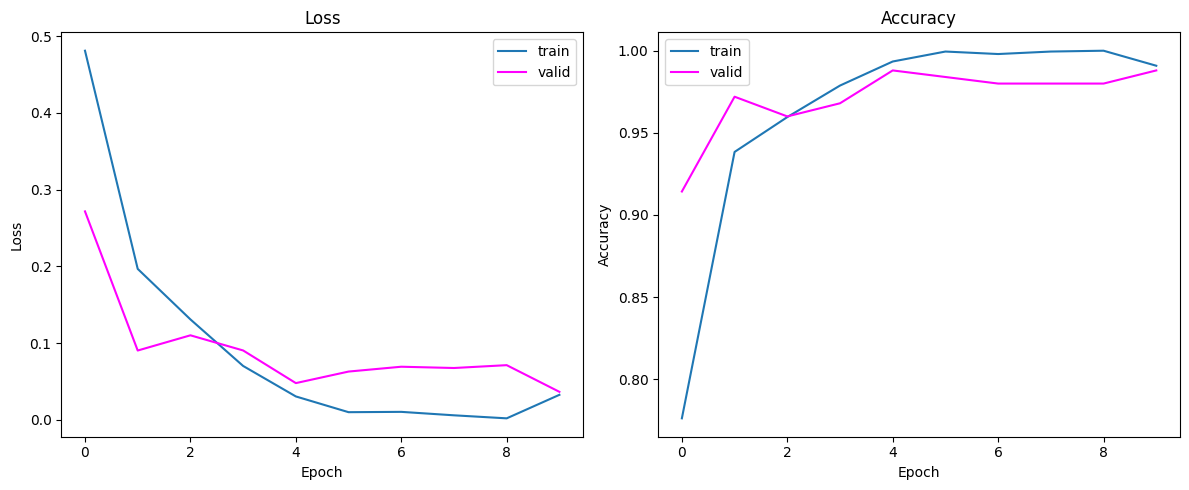

In [24]:
criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001) # WHY 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer
)


### Finetune the pre-trained model

In [19]:
import numpy as np
import time
from tqdm import tqdm

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder_resnet = './models_resnet'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=resnet_model,
    loaders=loaders,
    loss_f=criterion,
    optimizer=optimizer
)

cuda


### Does data augmentation improve model performance?

In [ ]:
# with combined data set/ DATA AUGMENTATION AND OVERSAMPLING: TO DO: only apply to training set!

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=model,
    loaders=loaders,
    loss_f=criterion,
    optimizer=optimizer
)


2952
cuda


100%|██████████| 30/30 [00:01<00:00, 22.93it/s]


Epoch 1
Training Loss: 0.3220, Training Acc: 0.8878
Validation Loss: 0.1446, Validation Acc: 0.9700
-------------------
Validation Loss Decreased (inf --> 0.1446) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 24.25it/s]


Epoch 2
Training Loss: 0.1859, Training Acc: 0.9422
Validation Loss: 0.1001, Validation Acc: 0.9733
-------------------
Validation Loss Decreased (0.1446 --> 0.1001) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 19.24it/s]


Epoch 3
Training Loss: 0.1386, Training Acc: 0.9557
Validation Loss: 0.0697, Validation Acc: 0.9800
-------------------
Validation Loss Decreased (0.1001 --> 0.0697) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 24.21it/s]


Epoch 4
Training Loss: 0.1135, Training Acc: 0.9646
Validation Loss: 0.0622, Validation Acc: 0.9867
-------------------
Validation Loss Decreased (0.0697 --> 0.0622) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 24.89it/s]


Epoch 5
Training Loss: 0.1293, Training Acc: 0.9506
Validation Loss: 0.0524, Validation Acc: 0.9867
-------------------
Validation Loss Decreased (0.0622 --> 0.0524) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 24.56it/s]


Epoch 6
Training Loss: 0.1323, Training Acc: 0.9557
Validation Loss: 0.0549, Validation Acc: 0.9867
-------------------


100%|██████████| 30/30 [00:01<00:00, 23.77it/s]


Epoch 7
Training Loss: 0.1378, Training Acc: 0.9464
Validation Loss: 0.0450, Validation Acc: 0.9900
-------------------
Validation Loss Decreased (0.0524 --> 0.0450) 	 Saving The Model


100%|██████████| 30/30 [00:01<00:00, 25.01it/s]


Epoch 8
Training Loss: 0.1218, Training Acc: 0.9506
Validation Loss: 0.0634, Validation Acc: 0.9767
-------------------


100%|██████████| 30/30 [00:01<00:00, 15.45it/s]


Epoch 9
Training Loss: 0.1056, Training Acc: 0.9612
Validation Loss: 0.0469, Validation Acc: 0.9833
-------------------


100%|██████████| 30/30 [00:01<00:00, 24.38it/s]


Epoch 10
Training Loss: 0.1315, Training Acc: 0.9498
Validation Loss: 0.0331, Validation Acc: 0.9900
-------------------
Validation Loss Decreased (0.0450 --> 0.0331) 	 Saving The Model
Average training time per epoch on cuda: 0.20300549546877544 minutes
Total training time: 2.0300549546877544 minutes


## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [14]:
# Code modified after Computer_vision_exercise_solutions.ipynb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct += (preds == test_labels).sum().item()
            total += test_labels.size(0)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(test_labels.cpu().numpy().flatten())


    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)
    print(f"Test accuracy: {accuracy:.3f}")
    print(f"Test F1 Score: {f1:.3f}")


def evaluate_confusion_matrix(model: nn.Module, test_loader) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    lbl_pred = []
    lbl_test = []

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()

            lbl_pred.extend(preds.cpu().numpy().flatten())
            lbl_test.extend(test_labels.cpu().numpy().flatten())

    cm = confusion_matrix(lbl_test, lbl_pred)
    return cm

Test accuracy: 0.964
Test F1 Score: 0.970


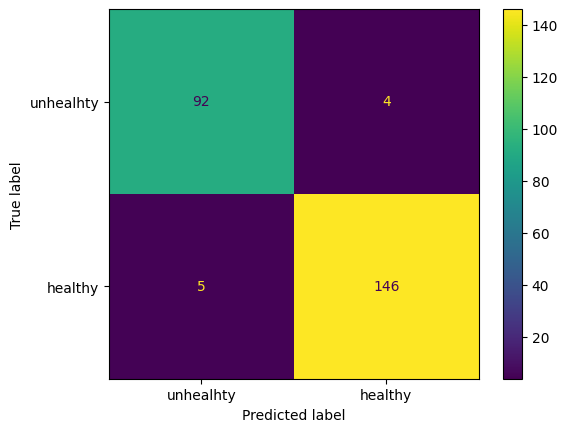

In [ ]:
baseline_model.load_state_dict(torch.load('./models/saved_model.pth'))
evaluate(baseline_model, loaders['test'])

cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

Test accuracy: 0.988
Test F1 Score: 0.990


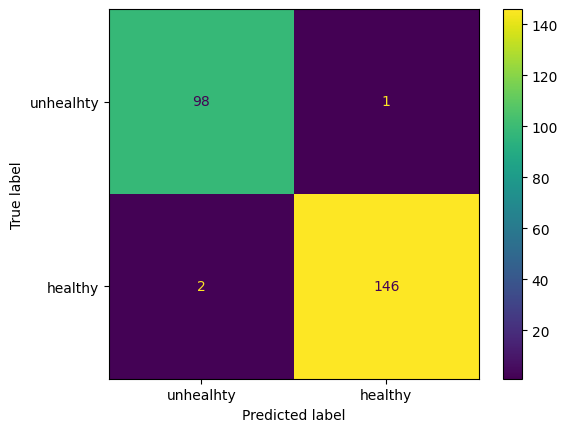

In [15]:
model.load_state_dict(torch.load('./models/saved_model.pth'))
evaluate(model, loaders['test'])
cm = evaluate_confusion_matrix(model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

In [ ]:
# DID DATA AUGMENTATION HELP????

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

In [ ]:
# Optuna or threshold tuning

### References
